In [2]:
!pip install elasticsearch

     |████████████████████████████████| 325 kB 1.2 MB/s eta 0:00:01


In [118]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import os
from subprocess import Popen, PIPE, STDOUT
from elasticsearch import Elasticsearch
import elasticsearch.helpers

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#Setting up ElasticSearch

!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
!curl -X GET "localhost:9200/"
es = Elasticsearch()
es.ping()

In [90]:
def read_data(source_file):
    
    data = pd.read_csv(source_file,index_col=0)
    data = data.fillna(0)
    
    return data

In [94]:
def insert_data(data, es, this_index):

    for row_id, row in data.iterrows():

        doc = row.to_dict()
        es.index(index= this_index, id= row_id, body= doc)
    

In [96]:
def scan_full_database(es, this_index):
    
    documents = elasticsearch.helpers.scan(es,
        index= this_index,
        preserve_order=True,
        query={"query": {"match_all": {}}},
    )
    
    return documents


In [109]:
def clean_text(text):
    
    text = re.sub('https?://\S+|www\.\S+', '', text) #Remove URL
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Remove punctuation
    
    return text

In [112]:
def NER_model(text):
    
    doc = nlp(text)
    return doc.ents

In [122]:

def get_entities (es, index):
    
    entity_dictionary = {}
    
    documents = scan_full_database(es, index)
    
    for document in documents:
        cleaned_tweet = clean_text(document["_source"]["tweet"])
        entities = NER_model(cleaned_tweet)
        
        for entity in entities:
            
            if (entity.label_ not in entity_dictionary):
                entity_dictionary[entity.label_] = {}
                
            if (entity.text not in entity_dictionary[entity.label_]):
                entity_dictionary[entity.label_][entity.text] = 0
                
            entity_dictionary[entity.label_][entity.text] += 1
            
    return entity_dictionary
        

In [130]:
def show_wordcloud(dictionary):
    wordcloud = WordCloud(max_words=50,normalize_plurals=False,background_color='white').generate_from_frequencies(dictionary)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [97]:
data = read_data("/kaggle/input/all-trumps-twitter-insults-20152021/trump_insult_tweets_2014_to_2021.csv")
insert_data(data, es, "trump_tweets")


In [123]:
entity_dictionary = get_entities(es, "trump_tweets")

PERSON


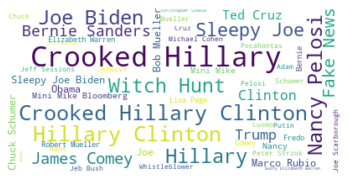

ORG


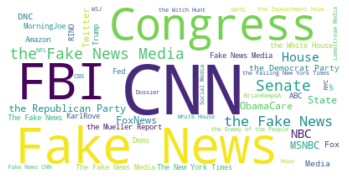

GPE


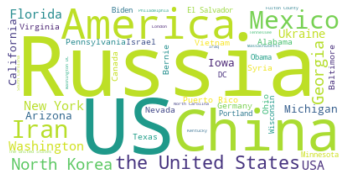

DATE


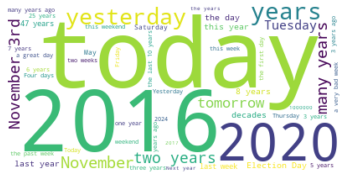

WORK_OF_ART


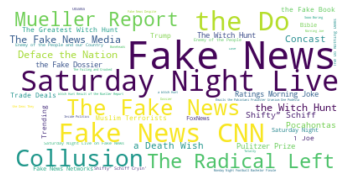

CARDINAL


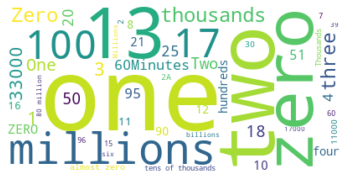

ORDINAL


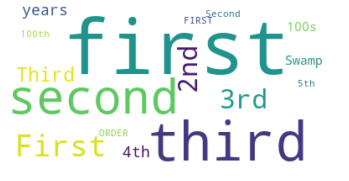

TIME


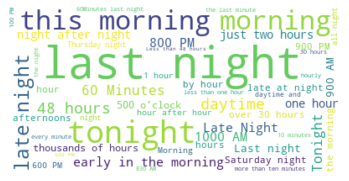

NORP


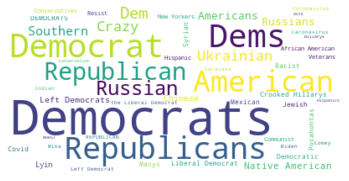

MONEY


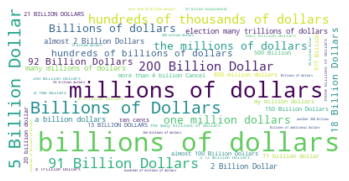

FAC


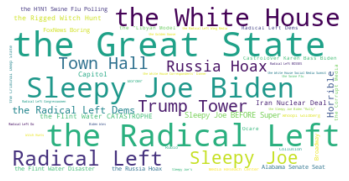

LAW


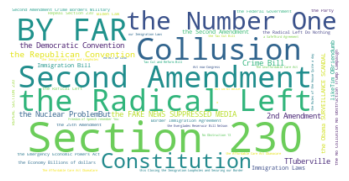

EVENT


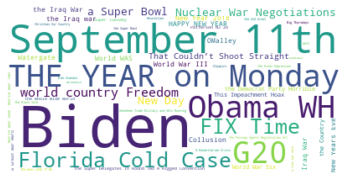

PRODUCT


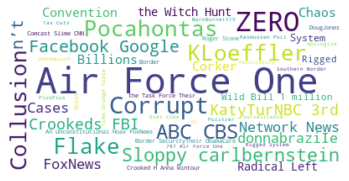

PERCENT


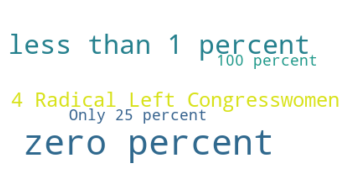

LOC


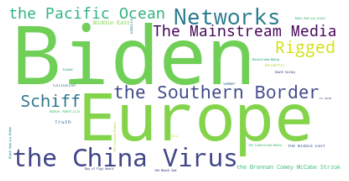

QUANTITY


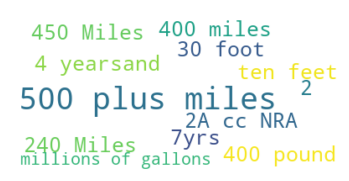

LANGUAGE


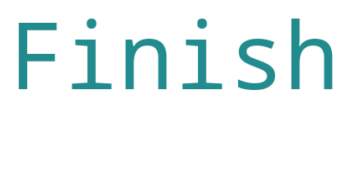

In [134]:
for key in entity_dictionary:
    
    #print(key)
    show_wordcloud(entity_dictionary[key])
    
    #print(key)
    #print(sorted(entity_dictionary[key].items(), key = 
             #lambda kv:(kv[1], kv[0]), reverse = True)[:10])
    
    #print()